# Resampling

In [1]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## fastai imports
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *
from exp.nb_AudioCommon import *
from exp.nb_DataBlock import *
from exp.nb_DataAugmentation import *

In [3]:
## The actual url is http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz
## but we need to strip off the extension otherwise fastai gets confused.
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
## Need this because the source tar file doesn't extract to its own folder
data_folder = datapath4file(url2name(data_url))
untar_data(data_url, dest=data_folder)

PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

In [4]:
audios = AudioList.from_folder(data_folder); audios

AudioList (3842 items)
AudioItem: 6.24sec (99840 @ 16000hz).,AudioItem: 7.4sec (118400 @ 16000hz).,AudioItem: 2.84sec (45440 @ 16000hz).,AudioItem: 3.36sec (53760 @ 16000hz).,AudioItem: 3.84sec (61440 @ 16000hz).
Path: /home/h/.fastai/data/ST-AEDS-20180100_1-OS

160000

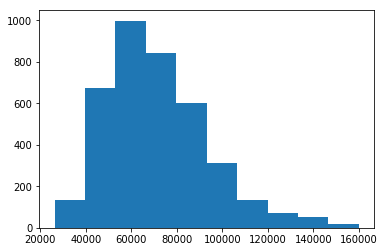

In [5]:
audio_lengths = tensor([a.data.sig.shape[0] for a in audios])
plt.hist(audio_lengths);
audio_lengths.max().item()

In [16]:
def tfms_sr(resample_rate):
    sr = resample_rate
    n_mels = 64
    n_fft = int(np.ceil(0.025*sr))
    win_length = int(np.ceil(0.025*sr))
    hop_length = int(np.ceil(0.010*sr))
    window = 'hamming'
    return get_audio_transforms(resample_rate=resample_rate,
                            spectro=True,
                            mx_to_pad=120000,
                            white_noise=False,
                            modulate_volume=False,
                            random_cutout=False,
                            pad_with_silence=False,
                            pitch_warp=False,
                            down_and_up=False,
                            n_mels=n_mels, ws=win_length, n_fft=n_fft,
                            hop_length=hop_length,
                            to_db_scale=True,
    )

In [11]:
## Regex to get the speaker ID in our file name (our label)
label_pattern = r'_([mf]\d+)_'
bs = 64
label_data = (audios
        .split_by_rand_pct(0.2, seed=2)
        .label_from_re(label_pattern)
 )

In [8]:
def make_learner(data):
    newlayer = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    newlayer = newlayer.cuda() # Our layer should use cuda, since the rest of the model will.
    ## Standard learner
    learn = cnn_learner(data, models.resnet18, metrics=accuracy)
    ## Replace the first layer in the resnet18 model with our first layer
    learn.model[0][0] = newlayer
    return learn

Using sample rate:  15500


torch.Size([1, 64, 619])


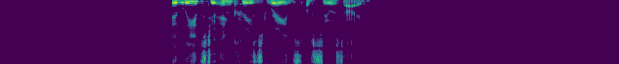

epoch,train_loss,valid_loss,accuracy,time
0,1.994467,1.136987,0.598958,00:09
1,1.430035,0.777825,0.733073,00:09
2,1.147634,0.711349,0.746094,00:09
3,0.997032,0.622039,0.776042,00:09
4,0.893363,0.598109,0.779948,00:09


Using sample rate:  12000


torch.Size([1, 64, 801])


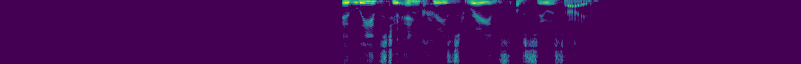

epoch,train_loss,valid_loss,accuracy,time
0,1.950276,1.320331,0.542969,00:09
1,1.383365,0.826282,0.717448,00:09
2,1.088608,0.686658,0.774740,00:09
3,0.927301,0.670661,0.779948,00:09
4,0.827211,0.649170,0.781250,00:09


Using sample rate:  10000


torch.Size([1, 64, 961])


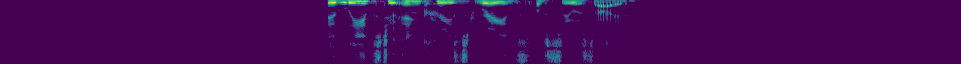

epoch,train_loss,valid_loss,accuracy,time
0,2.004604,1.459823,0.464844,00:09
1,1.309481,0.699769,0.760417,00:09
2,0.994182,0.578482,0.804688,00:09
3,0.788946,0.503056,0.828125,00:09
4,0.694022,0.492288,0.828125,00:09


Using sample rate:  8000


torch.Size([1, 64, 1201])


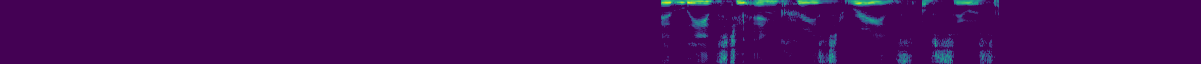

epoch,train_loss,valid_loss,accuracy,time
0,1.994034,1.594125,0.542969,00:10
1,1.324417,0.796036,0.726562,00:09
2,0.996297,0.521823,0.821615,00:09
3,0.810807,0.485281,0.841146,00:09
4,0.720825,0.468674,0.852865,00:10


In [17]:
for i in [15500, 12000, 10000, 8000]:
    tfms = tfms_sr(i)
    print("Using sample rate: ", i)
    db = label_data.transform(tfms).databunch(bs=bs)
    db.train_ds[0][0].show()
    learn = make_learner(db)
    learn.fit_one_cycle(5)